# Continuidade Operacional: Projeto Preditivo de Manutenção de Máquinas

<img src="https://proconcept.com.br/wp-content/uploads/2022/06/tipos-manutencao-preditiva-768x432.jpg.webp" height="200" width="400">


**By:** Ana Maria Pego Pinheiro

<font size="5"><a id="sumario"><bold>Summary</bold></a></font>
***
>1. [Imports](#ses1)
>2. [Informações conjunto de dados](#ses2)
>3. [--](#ses3)
>4. [--](#ses4)


<h2><a id="ses1">Imports</a></h2>

[Voltar](#sumario)

In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from matplotlib import pyplot
import warnings
from IPython.display import display
import xgboost as xg
from xgboost import XGBClassifier

In [6]:
# Para ignorar mensagens de alertas 
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# Saída das tabelas
np.set_printoptions(threshold=None, precision=2)


<span style="color: #cca002">**Obs:**</span>

<h2><a id="ses2">Informações do conjunto de dados</a></h2>

[Voltar](#sumario)

O conjunto de dados para o desenvolvimento desse projeto é o [AI4I 2020 Predictive Maintenance Dataset - UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset). São um conjunto de dados sintético que reflete a manutenção preditiva real encontrada na indústria.

O conjunto de dados consiste em 10 mil linhas e 10 colunas:

* UID: identificador exclusivo variando de 1 a 10.000;

* ProductID: consistindo em uma letra L, M ou H para baixa (50% de todos os produtos), média (30%) e alta (20%) como variantes de qualidade do produto e um número de série específico da variante;

* Air temperature [K]: gerada usando um processo de passeio aleatório posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K;

* Process temperature [K]: gerada usando um processo de passeio aleatório normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K;

* Rotational speed [rpm]: calculada a partir de potência de 2860 W, sobreposta a um ruído normalmente distribuído;

* Torque [Nm]: os valores de torque são normalmente distribuídos em torno de 40 Nm com Ïƒ = 10 Nm e sem valores negativos;

* Tool wear [min]: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta utilizada no processo. e um rótulo de 'falha da máquina' que indica se a máquina falhou neste ponto de dados específico para qualquer um dos seguintes modos de falha;

* Target: Falha ou Não;

* Failure Type: Tipo de falha;

<h2><a id="ses3">Análise Exploratória</a></h2>

[Voltar](#sumario)

In [36]:
colors = sns.color_palette('pastel')
display(colors)
print(colors.as_hex())

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#cfcfcf', '#fffea3', '#b9f2f0']


In [11]:
# load data
dataset = pd.read_csv("./Data/predictive_maintenance.csv")
print('Dimensão dataset:', dataset.shape, '\n')
dataset.head()

Dimensão dataset: (10000, 10) 



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [10]:
# checking the type of columns and null values

null_df = dataset.isnull().sum() * 100/len(dataset)

info_df = pd.DataFrame({'qtd_missing': dataset.isnull().sum(),
                       'percent_missing': null_df,
                       'dtype': dataset.dtypes}
                      ).reset_index().rename(columns={'index': 'column'})
info_df

,column,qtd_missing,percent_missing,dtype
0,UDI,0,0.0,int64
1,Product ID,0,0.0,object
2,Type,0,0.0,object
3,Air temperature [K],0,0.0,float64
4,Process temperature [K],0,0.0,float64
5,Rotational speed [rpm],0,0.0,int64
6,Torque [Nm],0,0.0,float64
7,Tool wear [min],0,0.0,int64
8,Target,0,0.0,int64
9,Failure Type,0,0.0,object


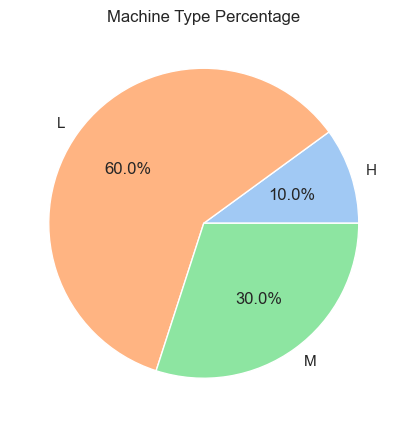

In [14]:
qtd_product_type = dataset[['Product ID','Type']].groupby('Type').count().reset_index()


sns.set(rc={'figure.figsize':(5,6)})
colors = sns.color_palette('pastel')
g = plt.pie(x=qtd_product_type['Product ID'],
    labels=qtd_product_type['Type'],colors = colors, autopct='%.1f%%')

plt.title("Machine Type Percentage")
plt.show()

Analyzing the main machine failures:

Number of failed and non-failed machines:
0 (No Failure): 1 (Failure):


,Target,Product ID
0,0,9661
1,1,339



Frequency of failure type:


,index,Failure Type,Target
0,1,No Failure,9652
1,0,Heat Dissipation Failure,112
2,3,Power Failure,95
3,2,Overstrain Failure,78
4,5,Tool Wear Failure,45
5,4,Random Failures,18


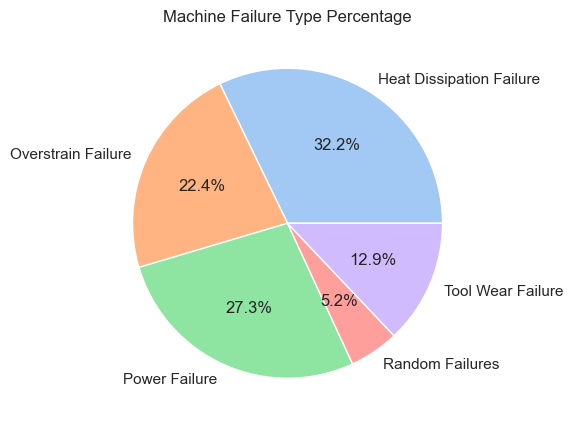

In [25]:
print('Analyzing the main machine failures:\n')

print('Number of failed and non-failed machines:\n0 (No Failure): 1 (Failure):')
target = dataset[['Product ID', 'Target']].groupby('Target', as_index=False).count()
display(target)


print('\nFrequency of failure type:')
type_failure = dataset[['Failure Type', 'Target']].groupby('Failure Type', as_index=False).count().sort_values('Target', ascending=False).reset_index()
display(type_failure)

qtd_failure = dataset[['Target','Failure Type']].loc[(dataset['Failure Type'] != 'No Failure')
                                                   ].groupby('Failure Type').count().reset_index()

sns.set(rc={'figure.figsize':(5,6)})
colors = sns.color_palette('pastel')
g = plt.pie(x=qtd_failure['Target'],
    labels=qtd_failure['Failure Type'],colors = colors, autopct='%.1f%%')

plt.title("Machine Failure Type Percentage")

plt.show()

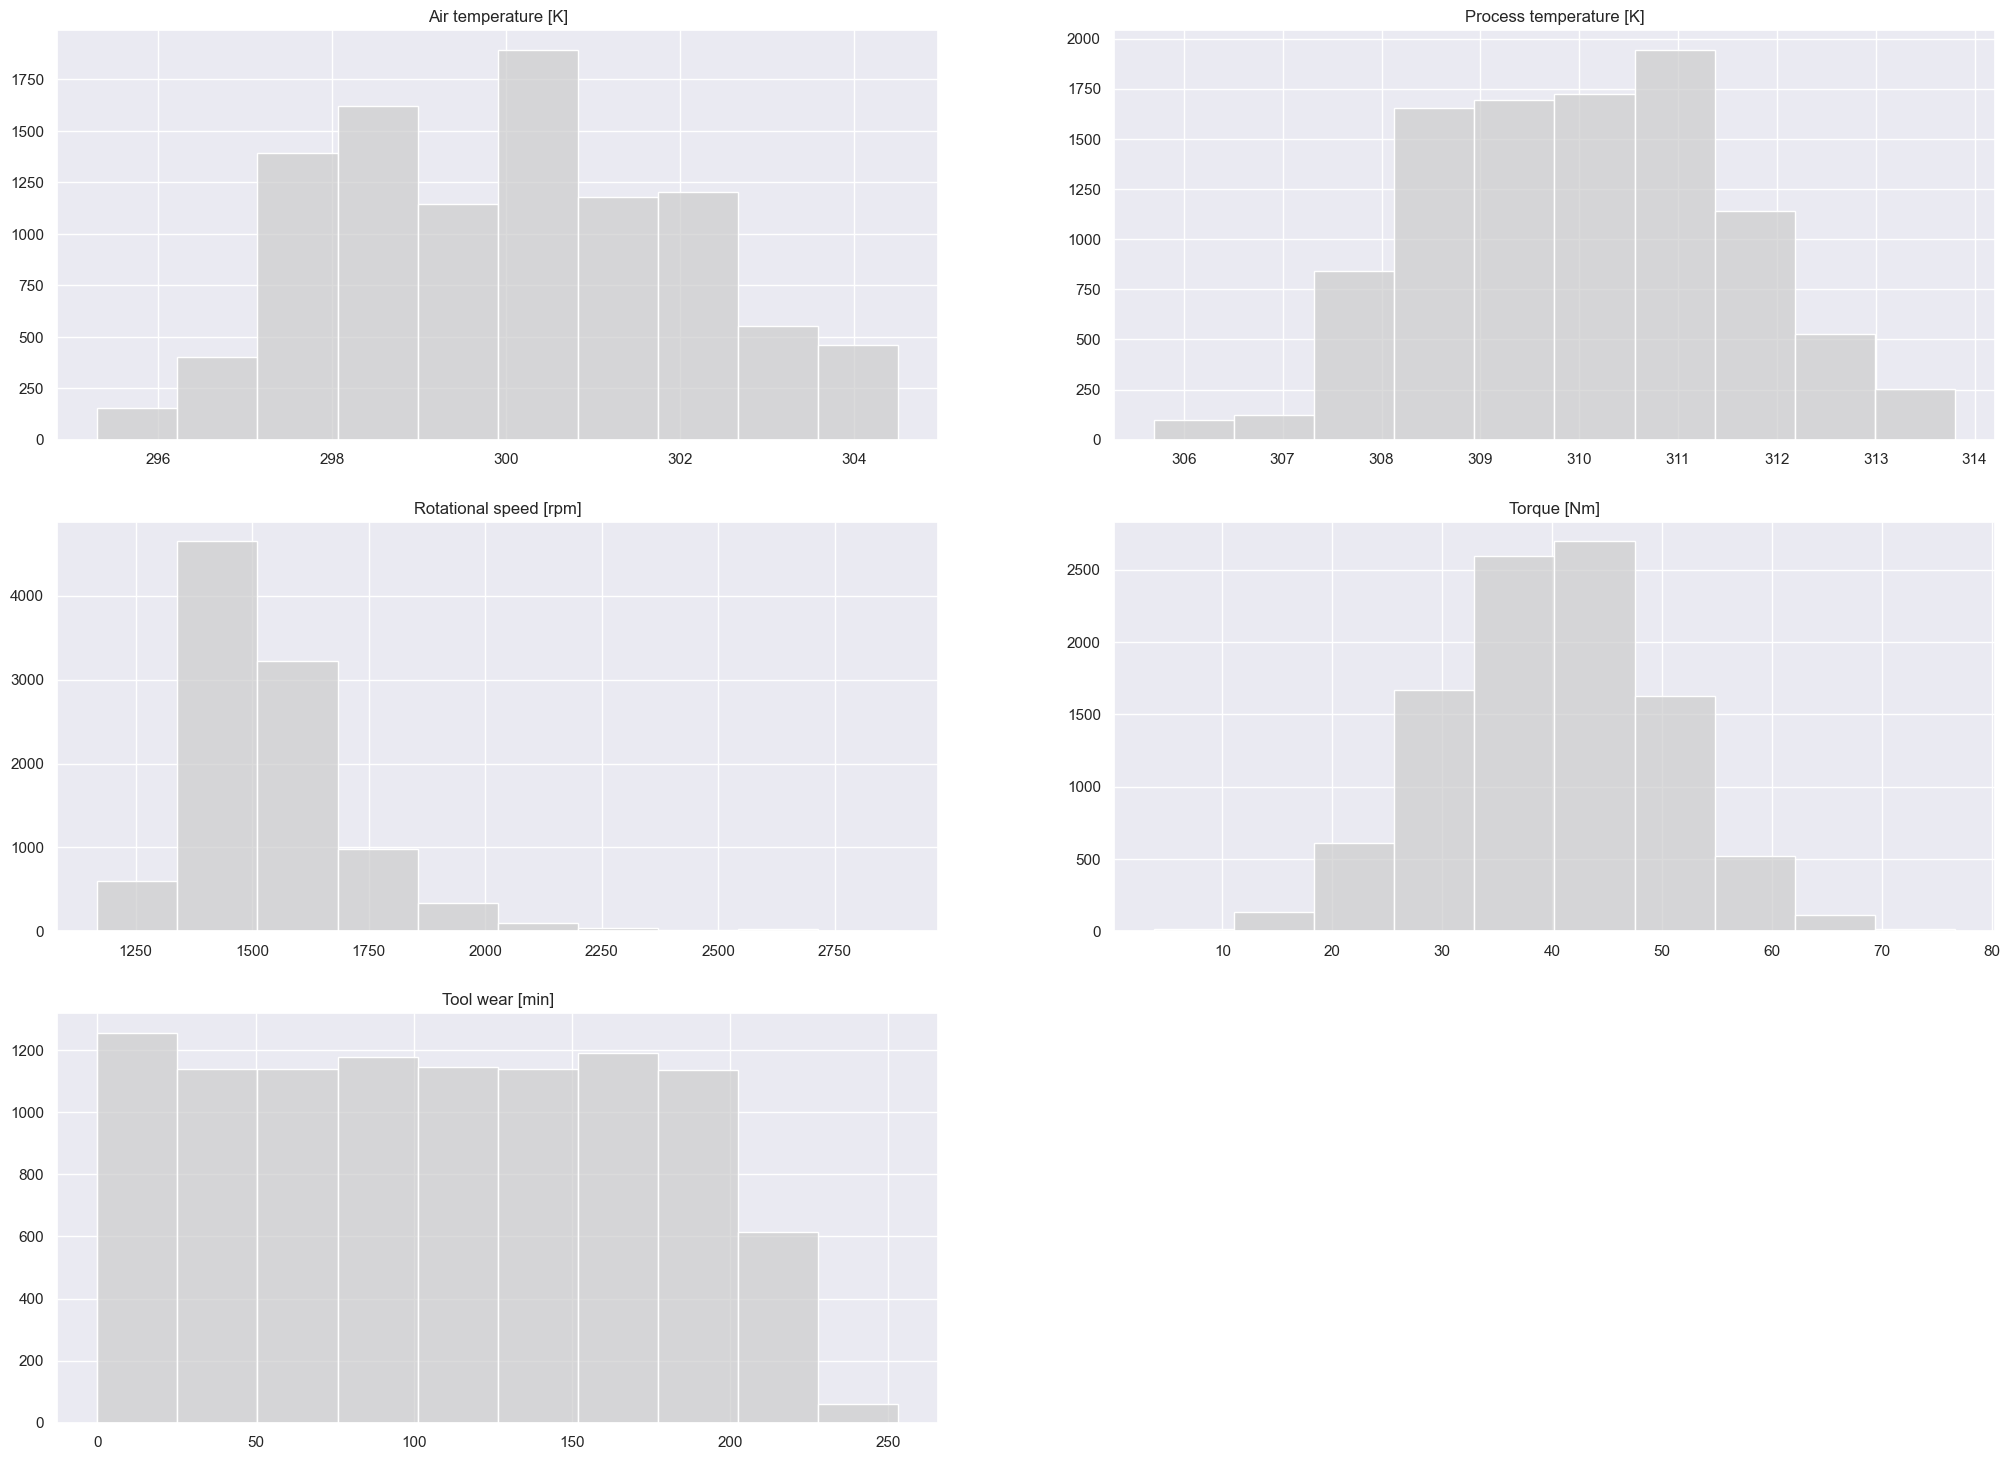

In [37]:
# 

columns_number = dataset.drop(columns=['Target', 'UDI']).select_dtypes(exclude=['object']).columns

plt.figure(figsize=(25, 50))
col_count = 1

for col in columns_number[:10]:
    plt.subplot(8, 2, col_count)
    sns.histplot(x=dataset[col], kde=False, bins=10, color='#cfcfcf')
    
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('')

    col_count += 1

plt.show()


In [11]:
# removing characters not relevant columns name

def rename_coll(x:pd.DataFrame) -> pd.DataFrame: 
    x.columns=x.columns.str.replace(r'\s*\[.*?\]\s*', '', regex=True).str.title().str.replace(' ', '')
    
rename_coll(dataset)

In [12]:
# the ProductId column has the product type in its values, which is not necessary because in dataset it 
# has a column with product type

# remove type
dataset['ProductId'] = dataset['ProductId'].apply(lambda x: x[1:])
dataset['ProductId'] = pd.to_numeric(dataset['ProductId'])

In [13]:
# remove column UDI

dataset.drop(columns=['Udi'], axis=1, inplace=True)

In [13]:
dataset

,ProductId,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType
0,14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...
9995,24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,39412,H,299.0,308.7,1408,48.5,25,0,No Failure


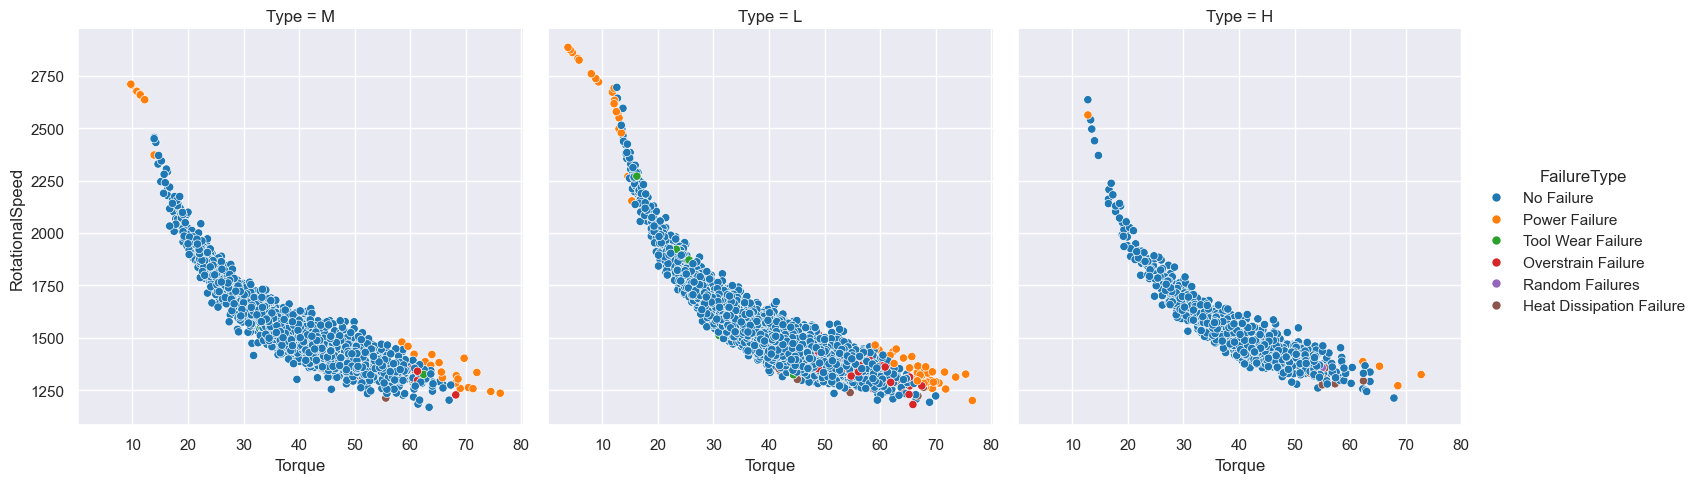

In [14]:
sns.relplot(data=dataset, x="Torque", y="RotationalSpeed", hue="FailureType",col="Type",palette='tab10');


####  Enconding e Scaling

In [15]:
dataset.head()

,ProductId,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType
0,14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [16]:
# enconding in variable categoria ordering

code_type = {'L': 0, 'M': 1,  'H': 2}

dataset['Type'] = dataset['Type'].map(code_type)

In [17]:
# enconding in variable categoria not ordering

code_failure = {'No Failure': 0,'Heat Dissipation Failure': 1,'Power Failure': 2,'Overstrain Failure': 3,
                'Tool Wear Failure': 4,'Random Failures': 5 }

dataset['FailureType'] = dataset['FailureType'].map(code_failure)

In [18]:
print('Correlation')
dataset.corr().style.background_gradient(cmap='coolwarm')

Correlation


,ProductId,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType
ProductId,1.000000,-0.752264,0.023137,0.063626,0.003413,0.000427,0.005869,0.026477,0.033809
Type,-0.752264,1.000000,-0.015176,-0.012101,-0.003979,-0.003097,-0.007255,-0.036715,-0.032077
AirTemperature,0.023137,-0.015176,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.040470
ProcessTemperature,0.063626,-0.012101,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.026149
RotationalSpeed,0.003413,-0.003979,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,-0.025110
Torque,0.000427,-0.003097,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,0.142830
ToolWear,0.005869,-0.007255,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.140449
Target,0.026477,-0.036715,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.793655
FailureType,0.033809,-0.032077,0.040470,0.026149,-0.025110,0.142830,0.140449,0.793655,1.000000


In [32]:
from sklearn.model_selection import train_test_split

# separando a variável alvo das demais
target = dataset[['Target']]
subset = dataset.drop(columns = ['Target', 'FailureType'])

# separando os datasets em treino e teste
X_train, X_test, y_train, y_test = train_test_split(subset,target,  test_size = 0.30, random_state=0)

# verificando a dimensão dos dados de treino e teste
print(f'Dados para Treino: {X_train.shape[0]} amostras')
print(f'Dados para Teste: {X_test.shape[0]} amostras')

Dados para Treino: 7000 amostras
Dados para Teste: 3000 amostras


In [33]:
from xgboost import XGBClassifier


In [34]:
clf = XGBClassifier(n_estimators = 200,
                    max_depth = 10, 
                    learning_rate = 0.01,
                    subsample = 1,
                    random_state=0)

# Training the XGB classifier
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [35]:
# previsão dos dados
y_pred = clf.predict(X_test)

In [42]:
from sklearn import metrics

metrics.confusion_matrix(y_test, y_pred)

array([[2890,   11],
       [  45,   54]], dtype=int64)

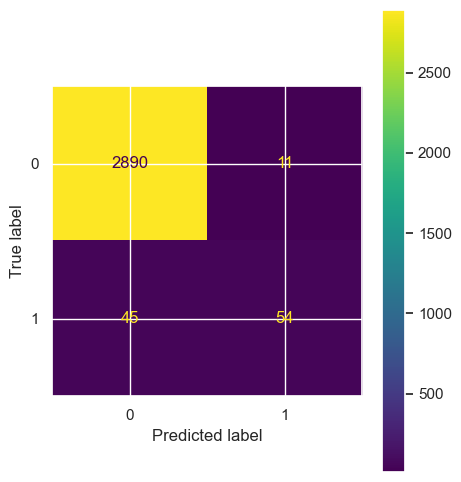

In [43]:
# apresentando os resultados pela Matriz de Confusão

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)  # Substitua 'predicted_labels' pelos rótulos previstos pelo seu modelo

# Cria o objeto ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)  # Substitua 'clf.classes_' pelos seus rótulos de classe

# Plota a matriz de confusão
disp.plot()

# Mostra o plot
plt.show()


In [46]:
# Acurácia 
from sklearn.metrics import accuracy_score

print(f'Precisão do modelo: {round(accuracy_score(y_test, y_pred)*100,3)}%')

Precisão do modelo: 98.133%


In [47]:
# Relatório da Classificação
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2901
           1       0.83      0.55      0.66        99

    accuracy                           0.98      3000
   macro avg       0.91      0.77      0.82      3000
weighted avg       0.98      0.98      0.98      3000



In [51]:
# Definir os conjuntos de avaliação
eval_set = [(X_train, y_train), (X_test, y_test)]

# Definir os parâmetros do modelo XGBoost
params = {
    'objective': 'multi:softmax',  # para problemas de classificação multiclasse
    'num_class': 3,                 # número de classes no conjunto de dados
    'eval_metric': 'merror',        # métrica de avaliação para otimização
    'max_depth': 3,                 # profundidade máxima da árvore
    'learning_rate': 0.1            # taxa de aprendizado
}

# Instanciar o modelo XGBoost
model = XGBClassifier(**params)

# Treinar o modelo XGBoost com os conjuntos de avaliação
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.02686	validation_1-merror:0.02900
[1]	validation_0-merror:0.02686	validation_1-merror:0.02900
[2]	validation_0-merror:0.02614	validation_1-merror:0.02767
[3]	validation_0-merror:0.02614	validation_1-merror:0.02767
[4]	validation_0-merror:0.02614	validation_1-merror:0.02767
[5]	validation_0-merror:0.02571	validation_1-merror:0.02733
[6]	validation_0-merror:0.02557	validation_1-merror:0.02733
[7]	validation_0-merror:0.02486	validation_1-merror:0.02733
[8]	validation_0-merror:0.02443	validation_1-merror:0.02533
[9]	validation_0-merror:0.02457	validation_1-merror:0.02533
[10]	validation_0-merror:0.02414	validation_1-merror:0.02500
[11]	validation_0-merror:0.02400	validation_1-merror:0.02467
[12]	validation_0-merror:0.02400	validation_1-merror:0.02467
[13]	validation_0-merror:0.02386	validation_1-merror:0.02467
[14]	validation_0-merror:0.02314	validation_1-merror:0.02433
[15]	validation_0-merror:0.02286	validation_1-merror:0.02433
[16]	validation_0-merror:0.02071	v

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [53]:
metricas = model.evals_result()

In [22]:
# PCA 
# https://www.geeksforgeeks.org/principal-component-analysis-with-python/